# NFインド株 日足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import re
import yfinance as yf

pattern = re.compile(r'(.+)\.T')

symbol = '1678.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-07-16 00:00:00+09:00,398.331163,398.724862,394.984646,398.429565,2855070,0.0,0.0,0.0
2024-07-17 00:00:00+09:00,398.232747,398.528014,395.575225,396.264221,2033870,0.0,0.0,0.0
2024-07-18 00:00:00+09:00,391.047612,392.524007,388.783820,390.555481,6485680,0.0,0.0,0.0
2024-07-19 00:00:00+09:00,394.590955,396.559480,393.901989,395.181519,3352860,0.0,0.0,0.0
2024-07-22 00:00:00+09:00,391.342909,392.425604,389.079086,391.244476,3377560,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-01-08 00:00:00+09:00,362.000000,362.799988,360.500000,360.500000,1294500,0.0,0.0,0.0
2025-01-09 00:00:00+09:00,361.100006,361.500000,359.500000,360.600006,1239070,0.0,0.0,0.0
2025-01-10 00:00:00+09:00,358.399994,361.100006,357.700012,360.100006,1855310,0.0,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

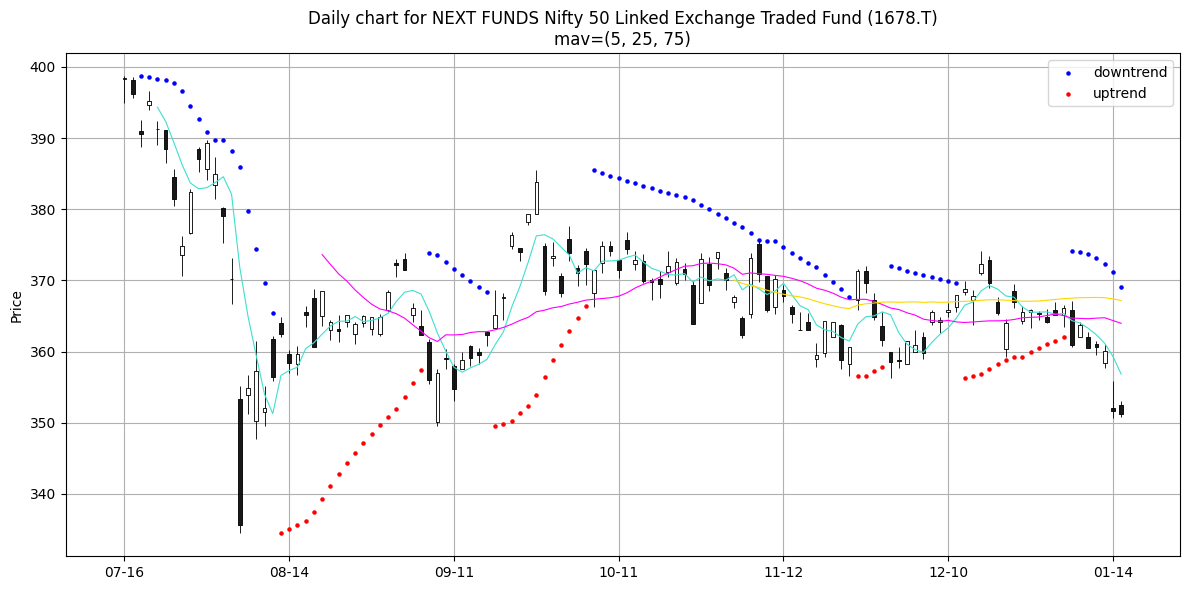

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-01-10 00:00:00+09:00    360.100006
2025-01-14 00:00:00+09:00    351.700012
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-01-10 00:00:00+09:00         NaN
2025-01-14 00:00:00+09:00   -8.399994
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-01-10 00:00:00+09:00    361.160004
2025-01-14 00:00:00+09:00    359.320007
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-01-10 00:00:00+09:00    364.755999
2025-01-14 00:00:00+09:00    364.363999
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-01-10 00:00:00+09:00    367.578665
2025-01-14 00:00:00+09:00    367.399999
Name: Close, dtype: float64